<html> <img style="float:center; margin: 0px 0px 0px 0px;" src="https://docs.google.com/uc? export=download&id=1jIxUCriI-tyCAkUYHz05rk5SY_rTHRV9" width="220" align="left"/> </html> 

<figure>
<center>
<img src='https://docs.google.com/uc?export=download&id=1BmLEthy7KCNsnVFviFKX77zLmFhc47XZ' align='right'width="220"/>
    
<figcaption>

</figcaption></center>
</figure>
<center> <H1> Analyse et Programmation avec Python </H1> </center>



Enseignant : Jaafar Chaaouri

Email: Jaafar.chaaouri@fsm.rnu.tn

---

## SOMMAIRE 

- Analyse de données
    - Le chiffre d'affaire et le volume
    - Les produits
    - Les clients
    - Le panier moyen
   
   
- réponses supplémentaires 
    - Y a-t-il une corrélation entre le sexe des clients et les catégories de - - produits achetés
    - Y a-t-il une corrélation entre l'âge des clients et :
        - le montant total des achats
        - la fréquence d’achat (ie. nombre d'achats par mois par exemple)
        - la taille du panier moyen (en nombre d’articles)
        - les catégories de produits achetés
        
        
- Proximité des produits

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

from datetime import datetime

import scipy.stats as st
import statsmodels.api as sm

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


###### Ouverture des données

In [ ]:
produits_invendus = pd.read_csv('/content/drive/My Drive/dataset/clean_dataset/produits_invendus.csv')
clients_sans_achat = pd.read_csv('/content/drive/My Drive/dataset/clean_dataset/clients_sans_achat.csv')
transactions = pd.read_csv('/content/drive/My Drive/dataset/clean_dataset/transactions.csv', parse_dates=[12])

In [ ]:
transactions.head(2)

,c_id,c_sex,c_birth,c_age,c_age_range,p_id,p_cat,p_price,p_price_range,t_sess_id,t_buyer_age,t_buyer_age_range,t_date,t_hour,t_weekday,t_month_part,t_month,data_info
0,c_4410,f,1967.0,55.0,51-70,1_385,1,25.99,expensive 20-79,s_9707,54.0,51-70,2021-03-22 01:40:22.782925,1.0,0.0,2,3.0,NaN
1,c_4410,f,1967.0,55.0,51-70,0_1110,0,4.71,cheap 4-9,s_114715,54.0,51-70,2021-11-04 16:28:30.169021,16.0,3.0,0,11.0,NaN


In [ ]:
transactions.iplot 

# Analyse de données 

### Le chiffre d'affaires et le volume 

In [ ]:
# print(f"Sur la période, Le CA est de {transactions.p_price.sum():.0e} dt")
print(f"Sur la période, Le CA est de {transactions.p_price.sum(): } dt")

Sur la période, Le CA est de  5797674.41841556 dt


#### Evolution chronologique

##### CA et volume : vue globale

In [ ]:
df = transactions[['t_date', 'p_price']]
df = df.sort_values('t_date').reset_index()
df.p_price.sum()

5797674.41841556

In [ ]:
df.sample(2)

,index,t_date,p_price
10854,258832,2021-03-12 16:43:05.112213,15.54
167876,325193,2021-09-06 16:12:33.554738,5.99


In [ ]:
df['ca'] = np.cumsum(df.p_price)
df['volume'] = pd.Series(range(len(df))) + 1
df.tail()

,index,t_date,p_price,volume,ca
336811,175205,2022-02-28 23:56:57.196281,28.27,336812,5.797630e+06
336812,207910,2022-02-28 23:56:57.561424,13.11,336813,5.797643e+06
336813,53616,2022-02-28 23:57:12.741573,8.61,336814,5.797651e+06
336814,207932,2022-02-28 23:59:02.381670,15.99,336815,5.797667e+06
336815,207913,2022-02-28 23:59:58.040472,6.99,336816,5.797674e+06


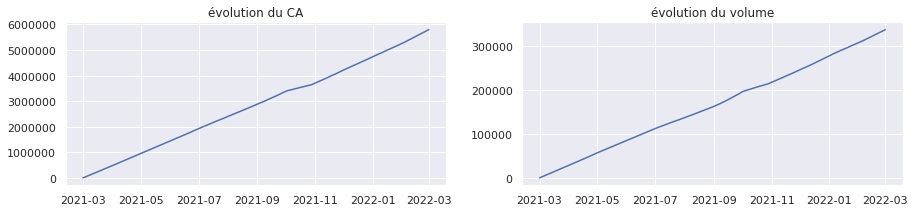

In [ ]:
plt.figure(figsize=(15,3))

plt.subplot(1,2,1)
plt.plot(df['t_date'], df['ca'])
plt.title('évolution du CA')

plt.subplot(1,2,2)
plt.plot(df['t_date'], df['volume'])
plt.title('évolution du volume')
plt.show()

In [ ]:
dates = transactions.t_date.sort_values().values
print(f'transactions de {dates[0]:} à {dates[-1]}')

transactions de 2021-03-01T00:01:07.843138000 à 2022-02-28T23:59:58.040472000


<div class="panel panel-primary">
    <div class="panel-heading">
        Aide à la décision
    </div>
    <div class="panel-body">
        Une évolution très constante. **Rien à signaler**. <br>
        Il semble tout de même qu'il y ait une **stagnation** sur le mois d'octobre
    </div>
</div>


##### CA et volume : vue précise

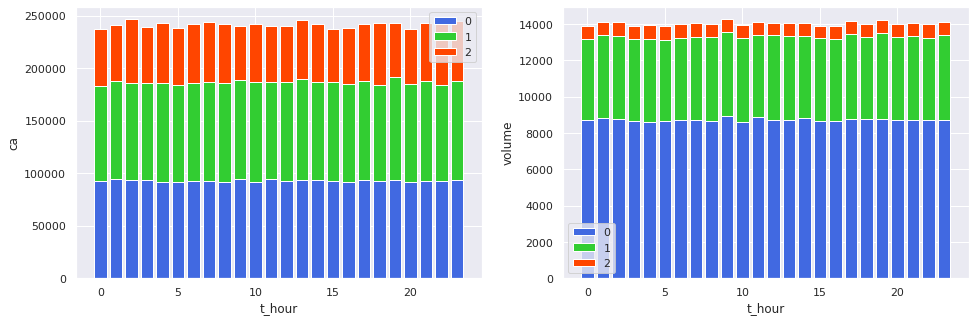

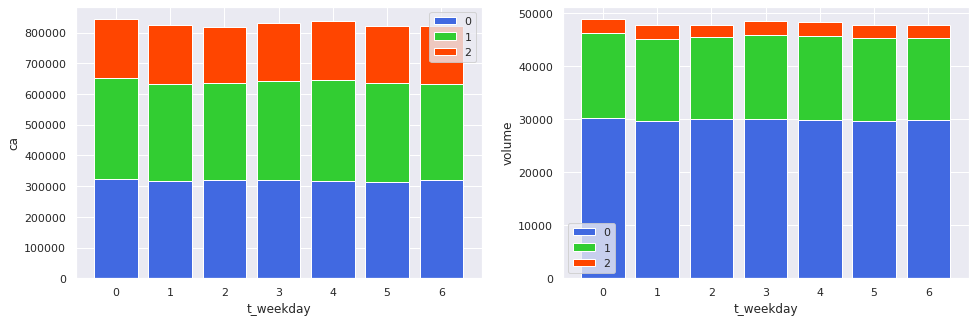

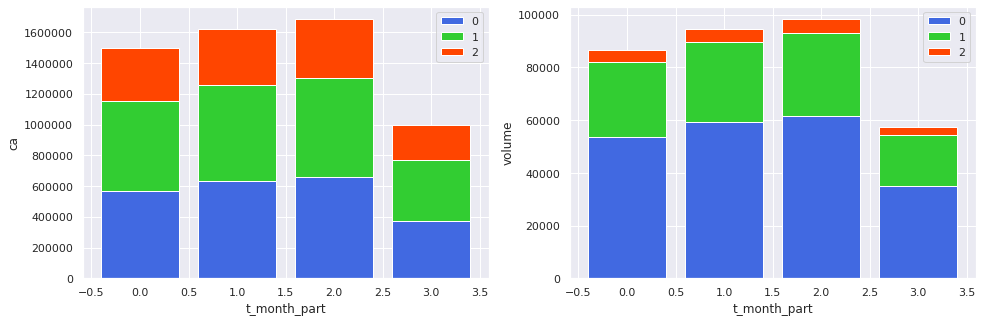

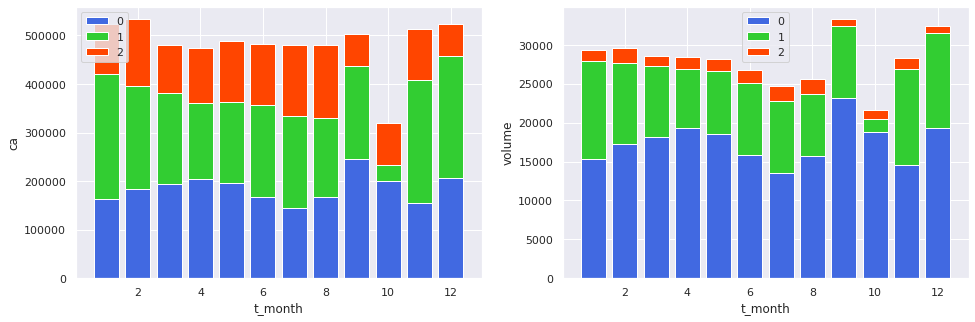

In [ ]:
cat_names = np.sort(transactions.p_cat.unique())

for time_unit in ['t_hour', 't_weekday', 't_month_part','t_month']:
    
    # on calcule un df qui contient l'unité de temps, la cat, et le prix
    df = transactions[[time_unit, 'p_cat', 'p_price']].groupby([time_unit, 'p_cat']).agg({'p_price':['sum', 'count']}).reset_index()
    df.columns = [time_unit, 'p_cat', 'ca', 'volume']
    
    # on determine les valeurs de temps en x
    x = df[time_unit].sort_values().unique()

    # pour chaque categories, on calcul les valeurs de ca et de volume des ventes
    cat_vals = []
    for cat in cat_names:
        ca = df[df.p_cat == cat].sort_values(time_unit).ca.values
        volume = df[df.p_cat == cat].sort_values(time_unit).volume.values
        cat_vals.append({'cat_name': cat, 'ca': ca, 'volume': volume})

    plt.figure(figsize=(16,5))
    for k, element in enumerate(['ca', 'volume']):
        plt.subplot(1,2,k+1)
        # pour le ca, puis le volume, on genere le graphique en bar
        colors = ['royalblue', 'limegreen', 'orangered']
        for i, cat in enumerate(cat_names):
            plt.bar(x, cat_vals[cat][element], 
                    color=colors[i],
                    label=cat_vals[cat]['cat_name'],
                    bottom = np.sum([cat_vals[j][element] for j in range(i)], axis=0))
        plt.xlabel(time_unit)
        plt.ylabel(element)
        plt.legend()

    plt.show()

# Aide à la décision

    - Evolution heure par heure  
    
    Une évoltion **très constante**. Le comportement ne change pas en fonction de l'heure de la journée.
    
    -  Evolution semaine par semaine 
    
    Même remarque pour les jours de la semaine.
    
    - Evolution en fonction du quart de mois  </h5>
    
    Les ventes augementent progressivement jusq'au 3eme quart. <br>
    Le dernier quart, on constate une diminution des ventes.
    
    - Evolution mensuel  
    
    Le volume diminue légèrement en été, mais régaumente fortement en septembre.
    en hiver (outre les ventes de cat. 1 étrangement basse en octobre), les ventes sont plus nombreuses.
    
    - Le CA est plus régulier que le volume : il y a des produits régulateurs.
    

In [ ]:
df = transactions.loc[
    :, 
    ['t_month', 'p_price', 'p_cat']]

df = pd.pivot_table(df, index='t_month', columns=['p_cat'], aggfunc=['sum', 'count']).reset_index()
df.columns = ['t_month', 'ca_0', 'ca_1', 'ca_2', 'vol0', 'vol1', 'vol2']

###### Saisonnalité et catégorie régulatrices

In [ ]:
df = transactions[['p_cat', 'p_price', 't_month']]
df = pd.pivot_table(df, index='t_month', columns=['p_cat'], aggfunc=['sum', 'count']).reset_index()
df.columns = ['t_month', 'ca_0', 'ca_1', 'ca_2', 'vol0', 'vol1', 'vol2']

Text(0.5, 1.0, 'evolution mensuelle du CA par cat.')

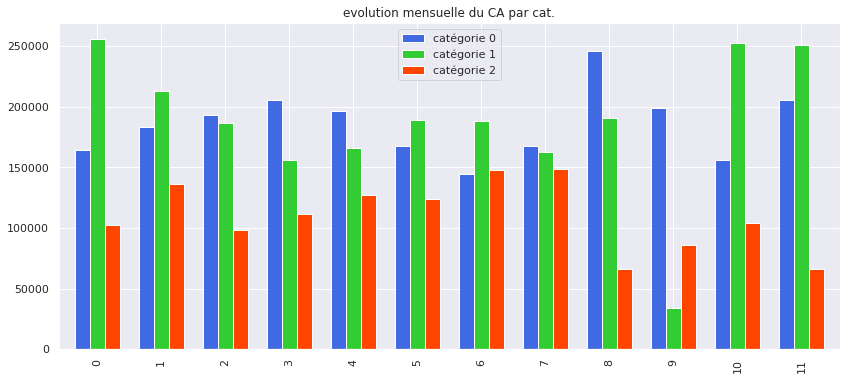

In [ ]:
df[['ca_0', 'ca_1', 'ca_2']].plot.bar(
    figsize=(14,6), 
    width=0.7, 
    color=['royalblue', 'limegreen', 'orangered']
)
plt.legend(['catégorie 0', 'catégorie 1', 'catégorie 2'])
plt.title('evolution mensuelle du CA par cat.')

Text(0.5, 1.0, 'evolution mensuelle du volume par cat.')

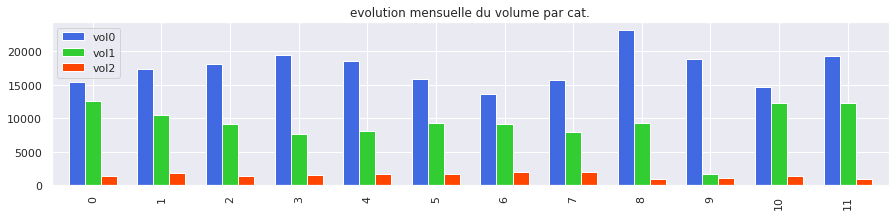

In [ ]:
df[['vol0', 'vol1', 'vol2']].plot.bar(
    figsize=(15,3), 
    width=0.7, 
    color=['royalblue', 'limegreen', 'orangered']
)
plt.title('evolution mensuelle du volume par cat.')

<div class="panel panel-primary">
<div class="panel-heading">
    Aide à la décision
</div>
<div class="panel-body">
    - on constate que, globalement, <br>
     - la vente de prod. cat2. diminue <br>
     - la vente de prod. de cat. 0 et 1 augmente et compense
</div>
</div>

###### baisse sur 4eme quart de mois

In [ ]:
df = transactions[['t_month_part', 'p_price']].groupby('t_month_part').agg({'p_price': ['sum', 'count']}).reset_index()
df.columns = ['t_month_part', 'ca', 'volume']

In [ ]:
ca_2 = df.loc[df.t_month_part == 2, 'ca'].values[0]
vol_2 = df.loc[df.t_month_part == 2, 'volume'].values[0]
ca_0 = df.loc[df.t_month_part == 0, 'ca'].values[0]
vol_0 = df.loc[df.t_month_part == 0, 'volume'].values[0]

tx_evol_ca = (ca_2 - ca_0) / ca_0
tx_evol_vol = (vol_2 - vol_0) / vol_0

In [ ]:
print(f"taux d'évolution entre le 1er et 3eme quart de mois : ")
print(f" - chiffre d'affaires : {tx_evol_ca*100:.0f}%")
print(f" - volume : {tx_evol_vol*100:.0f}%")

taux d'évolution entre le 1er et 3eme quart de mois : 
 - chiffre d'affaires : 12%
 - volume : 13%


In [ ]:
ca_3 = df.loc[df.t_month_part == 3, 'ca'].values[0]
vol_3 = df.loc[df.t_month_part == 3, 'volume'].values[0]
ca_2 = df.loc[df.t_month_part == 2, 'ca'].values[0]
vol_2 = df.loc[df.t_month_part == 2, 'volume'].values[0]

tx_evol_ca = (ca_3 - ca_2) / ca_2
tx_evol_vol = (vol_3 - vol_2) / vol_2

In [ ]:
print(f"taux d'évolution entre le 3eme et 4eme quart de mois : ")
print(f" - chiffre d'affaires : {tx_evol_ca*100:.0f}%")
print(f" - volume : {tx_evol_vol*100:.0f}%")

taux d'évolution entre le 3eme et 4eme quart de mois : 
 - chiffre d'affaires : -41%
 - volume : -42%


###### CA et vol. : Etude du mois d'octobre

In [ ]:
ca_sep = transactions.loc[transactions.t_month==9, 'p_price'].sum()
ca_oct = transactions.loc[transactions.t_month==10, 'p_price'].sum()

taux_evol_oct = (ca_oct - ca_sep) / ca_sep
taux_evol_oct

print(f"Taux d'évolution (ca) de sept. à oct.: {taux_evol_oct*100:.0f}%")

Taux d'évolution (ca) de sept. à oct.: -37%


- Vue chronologique

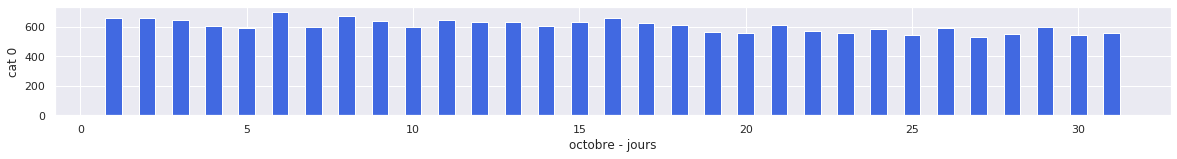

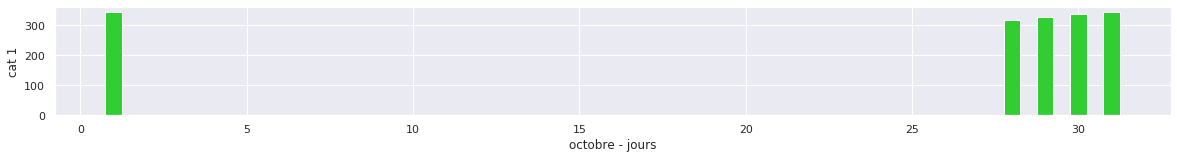

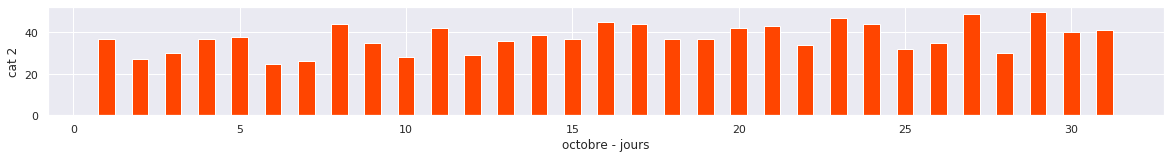

In [ ]:
# pour toute les transactions du mois d'octobre, 
# on aggrège, pour chaque jours (et par catégories), le CA et le volume
df = transactions.loc[transactions.t_month == 10, ['t_date', 'p_price', 'p_cat']]
df = df.groupby([df.t_date.dt.day, 'p_cat']).agg({'p_price':['sum', 'count']}).reset_index()
df.columns = ['t_day', 'p_cat', 'ca', 'volume']

# on pivote le df
# pour chaques jours (lignes), 6 colonnes : ca et volume des 3 cat.
df = pd.pivot_table(df, columns=['p_cat'], index=['t_day']).reset_index()
df.columns = ['t_day', 'ca_0', 'ca_1', 'ca_2', 'vol_0', 'vol_1', 'vol_2']

color=['royalblue', 'limegreen', 'orangered']
for i, cat in enumerate([0,1,2]):
    plt.figure(figsize=(44,2))
#     plt.subplot(1,2,1)
#     plt.bar(df['t_day'], df[f'ca_{cat}'], width=0.5)
#     plt.xlabel('octobre - jours')
#     plt.ylabel(f'CA - cat {cat}')
    plt.subplot(1,2,2)
    plt.bar(df['t_day'], df[f'vol_{cat}'], width=0.5, color=color[i])
    plt.xlabel('octobre - jours')
    plt.ylabel(f'cat {cat}')
    plt.show()

<div class="panel panel-primary">
<div class="panel-heading">
    Aide à la décision
</div>
<div class="panel-body">
    Vu a tendance annuel, il semble très étonnant qu'aucun produits de cat. 1 n'ai été vendus. <br>
    
    Il y a eu un **problème lors de récupération des données** sur les transactions de cat. 1 pour la période **du 2 au 27 octobre.**
</div>
</div>

### Les produits

In [ ]:
produits_vendus = transactions.loc[:, 'p_id':'p_price_range'].drop_duplicates()

#### les produits invendus

In [ ]:
print(f"{produits_invendus.shape[0] / (produits_vendus.shape[0] + produits_invendus.shape[0]) * 100 :.2f}% des produits sont invendus.")

0.67% des produits sont invendus.


<div class="panel panel-primary">
<div class="panel-heading">
    Aide à la décision
</div>
<div class="panel-body">
    La proportion de produits invendus est très faible et est négligeable.
</div>
</div>

#### les produits (vendus au moins une fois)

In [ ]:
cat_prices = {
    cat: produits_vendus.loc[
            (produits_vendus.p_cat==cat)
          & (produits_vendus.p_price),
        'p_price'
        ]
    for cat in [0,1,2]}

[]

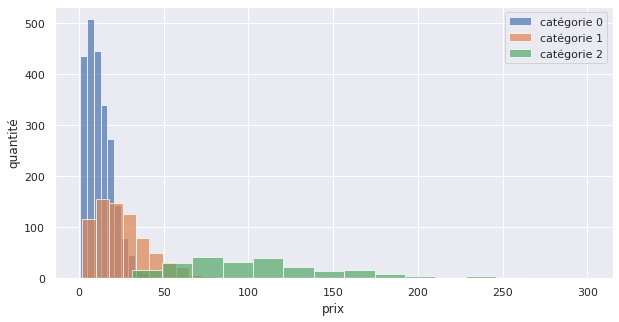

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(cat_prices[0], bins=10, alpha=0.7)
plt.hist(cat_prices[1], bins=10, alpha=0.7)
plt.hist(cat_prices[2], bins=15, alpha=0.7)
plt.legend(['catégorie 0', 'catégorie 1', 'catégorie 2'])
plt.xlabel('prix')
plt.ylabel('quantité')
plt.plot()

In [ ]:
cat_prices[2].describe()

count    236.000000
mean     107.636017
std       49.255576
min       30.990000
25%       70.690000
50%      101.250000
75%      134.945000
max      300.000000
Name: p_price, dtype: float64

[]

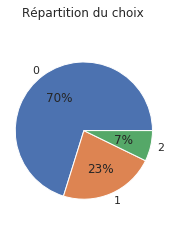

In [ ]:
freqs = produits_vendus.p_cat.value_counts()

plt.subplot(1,2,1)
plt.pie(freqs, autopct='%1.0f%%', labels=freqs.index.values)
plt.axis('equal')
plt.title('Répartition du choix')
plt.plot()

In [ ]:
df = transactions[['p_cat', 'p_price']].groupby('p_cat').agg({'p_price': ['count', 'sum']}).reset_index()
df.columns = ['p_cat', 'volume', 'ca']

[]

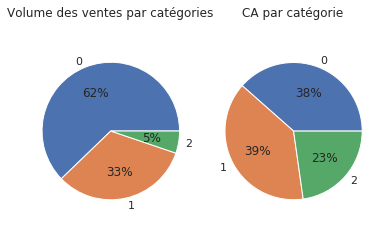

In [ ]:
plt.subplot(1,2,1)
plt.pie(df.volume, autopct='%1.0f%%', labels=freqs.index.values)
plt.axis('equal')
plt.title('Volume des ventes par catégories')
plt.plot()

plt.subplot(1,2,2)
plt.pie(df.ca, autopct='%1.0f%%', labels=freqs.index.values)
plt.axis('equal')
plt.title('CA par catégorie')
plt.plot()

<div class="panel panel-primary">
<div class="panel-heading">
    Aide à la décision
</div>
<div class="panel-body">
    Toute les catégories sont importantes. <br>
    **La catégorie 2 n'est pas a négliger**, même si elle représente 5% du volume des ventes, elle contribue au CA de 23%
</div>
</div>

#### Produits : Concentration des ventes

In [ ]:
a = transactions[['p_id', 'p_price']].groupby('p_id').agg({
    'p_price': ['count', 'sum']
}).reset_index()
a.columns = ['p_id', 't_number', 'ca']

##### Les produits les plus vendus

indice de gini: 0.69


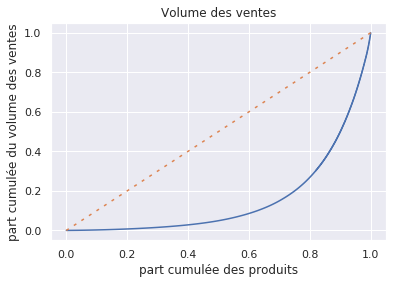

In [ ]:
t_number = a['t_number'].values
lorenz = np.cumsum(np.sort(t_number)) / t_number.sum()
lorenz = np.append([0], lorenz)

plt.plot(np.linspace(0,1,len(lorenz)), lorenz, drawstyle='steps-post')
plt.plot(np.linspace(0,1,len(lorenz)), np.linspace(0,1,len(lorenz)), dashes=[2,4])
plt.xlabel('part cumulée des produits')
plt.ylabel('part cumulée du volume des ventes')
plt.title('Volume des ventes')
aire_ss_courbe = lorenz[:-1].sum() / len(lorenz)
S = 0.5 - aire_ss_courbe
gini = 2*S
print(f'indice de gini: {gini:.2f}')

In [ ]:
p_plus_vendus = a[['p_id', 't_number']].sort_values('t_number', ascending=False)[:round(len(a)*0.2)]
prct_prod =  p_plus_vendus.p_id.count() / a.p_id.count() * 100
prct_ventes = p_plus_vendus.t_number.sum() / a.t_number.sum() * 100

print(f'{prct_ventes:.0f}% des ventes sont faites sur {prct_prod:.0f}% des produits ({len(p_plus_vendus)} prod). ')

73% des ventes sont faites sur 20% des produits (653 prod). 


In [ ]:
p_plus_vendus.head(2)

,p_id,t_number
2591,1_369,1081
2644,1_417,1062


<div class="panel panel-primary">
<div class="panel-heading">
    Aide à la décision
</div>
<div class="panel-body">
    *Loi des 80-20* <br>
    Il faut veiller au **stock** de ces produits. <br>
    Une rupture de l'un deux pourrait être très préjudiciable.
</div>
</div>

#### les produits les plus rémunérateurs : disparités

indice de gini: 0.74


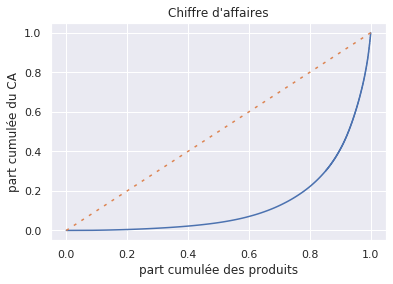

In [ ]:
t_number = a['ca'].values
lorenz = np.cumsum(np.sort(t_number)) / t_number.sum()
lorenz = np.append([0], lorenz)
plt.plot(np.linspace(0,1,len(lorenz)), lorenz, drawstyle='steps-post')
plt.plot(np.linspace(0,1,len(lorenz)), np.linspace(0,1,len(lorenz)), dashes=[2,4])
plt.ylabel('part cumulée du CA')
plt.xlabel('part cumulée des produits')
plt.title("Chiffre d'affaires")
aire_ss_courbe = lorenz[:-1].sum() / len(lorenz)
S = 0.5 - aire_ss_courbe
gini = 2*S
print(f'indice de gini: {gini:.2f}')

In [ ]:
p_plus_rtbles = a[['p_id', 'ca']].sort_values('ca', ascending=False)[:round(len(a)*0.2)]
nb_prod = len(p_plus_rtbles)
prct_prod =  p_plus_rtbles.p_id.count() / a.p_id.count() * 100
prct_ca = p_plus_rtbles.ca.sum() / a.ca.sum() * 100


print(f'les {prct_prod:.0f}% produits (soit {nb_prod} produits) les plus rentables rapportent {prct_ca:.0f}% du CA.')

les 20% produits (soit 653 produits) les plus rentables rapportent 78% du CA.


In [ ]:
p_plus_rtbles.head(2)

,p_id,ca
3070,2_135,33874.09
3045,2_112,31960.61


<div class="panel panel-primary">
<div class="panel-heading">
    Aide à la décision
</div>
<div class="panel-body">
    *loi des 80-20*. <br>
    Il faut concenter les **actions marketing** sur ces produits.
</div>
</div>

##### Quels sont les produits les plus rémunérateurs ?

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='pie')` instead of `Series.plot('pie',)`.
  after removing the cwd from sys.path.


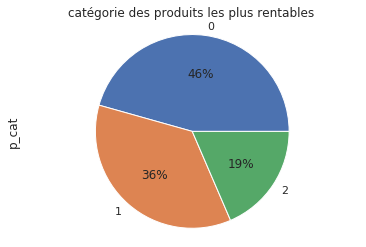

In [ ]:
df = produits_vendus[produits_vendus.p_id.isin(p_plus_rtbles.p_id.values)]
prod_plus_rtbles = pd.merge(df, a[['p_id', 't_number']], on='p_id')

prod_plus_rtbles.p_cat.value_counts(normalize=True).plot('pie',  autopct=lambda x:f'{x:.0f}%')
plt.axis('equal')
plt.title('catégorie des produits les plus rentables')
plt.show()

### Les clients 

In [ ]:
clients_avc_achat = transactions.loc[:,'c_id':'c_age_range'].drop_duplicates()

#### les clients sans achats

In [ ]:
print(f"Cela représente {clients_sans_achat.shape[0] / (clients_sans_achat.shape[0] + clients_avc_achat.shape[0]) * 100 :.2f}% des clients.")

Cela représente 0.24% des clients.


#### les clients avec achats

##### Sexe

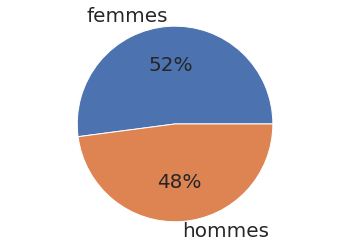

<Figure size 3600x3600 with 0 Axes>

In [ ]:
plt.pie(clients_avc_achat.c_sex.value_counts(), autopct=lambda x:f'{x:.0f}%',labels=['femmes', 'hommes'], 
        textprops={'fontsize': 20})

plt.axis('equal')
plt.figure(figsize=(50,50))
plt.show()

<div class="panel panel-primary">
<div class="panel-heading">
    Aide à la décision
</div>
<div class="panel-body">
    On constate une **forte parité** parmis la clientèle. <br>
    la communication *globale* de la marque ne doit pas renvoyer une image **genrée**.
</div>
</div>

##### Age

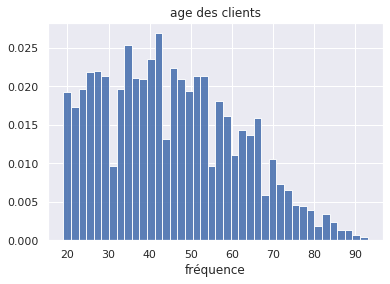

In [ ]:
ages_ss_18 = clients_avc_achat.loc[clients_avc_achat.c_age != 18, 'c_age']

plt.hist(ages_ss_18, density=True, bins=40, alpha=0.9)
plt.title('age des clients')
plt.xlabel('age')
plt.xlabel('fréquence')
plt.show()

In [ ]:
ages_ss_18.describe()

count    8163.000000
mean       45.117236
std        16.243253
min        19.000000
25%        32.000000
50%        44.000000
75%        57.000000
max        93.000000
Name: c_age, dtype: float64

<div class="panel panel-primary">
<div class="panel-heading">
    Aide à la décision
</div>
<div class="panel-body">
    Un pic anormal pour les gens de 18 ans. <br>
        - un formulaire d'inscription a revoir ? <br>
        - des mineurs qui s'inscrivent sur le site.
</div>
</div>

#### réparation des catégories d'ages

Text(0.5, 1.0, 'Contribution au CA')

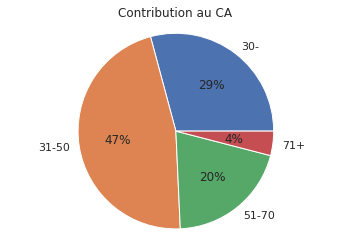

In [ ]:
df = transactions[['t_buyer_age_range', 'p_price']].groupby('t_buyer_age_range').sum().reset_index()
plt.pie(df.p_price, autopct='%1.0f%%', labels=df.t_buyer_age_range)
plt.axis('equal')
plt.title('Contribution au CA')

#### Fidélité des clients

In [ ]:
df = transactions[['c_id', 'p_cat']].copy()
df['count'] = 1

df = pd.pivot_table(df, columns='p_cat', index='c_id', aggfunc='count').reset_index()
df.columns = ['c_id', 'cat0', 'cat1', 'cat2']

df = df.fillna(0)
df['cat_fidele'] = df.loc[:,'cat0':'cat2'].max(axis=1) / df.loc[:,'cat0':'cat2'].sum(axis=1)
df.sample()

,c_id,cat0,cat1,cat2,cat_fidele
6132,c_653,7.0,5.0,0.0,0.583333


In [ ]:
fidele_cat = df.cat_fidele.mean()
print(f'en moyenne, {fidele_cat*100:.0f}% des produits acheté par un client proviennent de la même catégorie.')

en moyenne, 65% des produits acheté par un client proviennent de la même catégorie.


<div class="panel panel-primary">
<div class="panel-heading">
    Aide à la décision
</div>
<div class="panel-body">
    Les clients sont fidèles à une catégorie. <br>
    - Sur la page prod., on pourrait suggérer des produits d'une même catégorie <br>
    - Cibler une communication **par catégorie**
</div>
</div>

#### Les clients *spéciaux*

In [ ]:
df = transactions.groupby('c_id').agg({
    'c_age':'mean',
    'c_sex':lambda x: x.mode(),
    't_sess_id':'count',
    'p_price':['sum', 'count'],
    'p_id': ['nunique']
    })
df = df.reset_index()
df.columns = ['c_id', 'c_age', 'c_sex', 'nb_sess', 'ca', 'nb_t', 'nb_prod_diff']

In [ ]:
# on stocke leurs id
c_id_ab = df.loc[df.ca > 3000, 'c_id']
transactions.loc[transactions.c_id.isin(c_id_ab), 'data_info'] = 'c_special'

In [ ]:
df[df.c_id.isin(c_id_ab)]

,c_id,c_age,c_sex,nb_sess,ca,nb_t,nb_prod_diff
677,c_1609,42.0,m,12855,162007.340000,12855,1918
2724,c_3454,53.0,m,3275,54464.214144,3275,1092
4388,c_4958,23.0,m,2562,144257.210000,2562,466
6337,c_6714,54.0,f,4473,73218.634144,4473,1380


In [ ]:
clients_ab_ca = transactions.loc[transactions.data_info == 'c_special', 'p_price'].sum()
print(f'les {len(c_id_ab)} clients abbérants représentent {df[df.c_id.isin(c_id_ab)].ca.sum() / transactions.p_price.sum()*100:.0f}% du CA.')

les 4 clients abbérants représentent 7% du CA.


<div class="panel panel-primary">
<div class="panel-heading">
    Aide à la décision
</div>
<div class="panel-body">
    Ces 4 clients ont un comportement totalement différent. <br>
    Ce sont probablement des **libraires/bibliothèques** qui achètent en gros <br>
    <br>
    Ils contribuent à **7% du CA**. --> ils pourraient bénéficier **d'actions marketings et d'un accompagnement personnalisé**.
</div>
</div>

### Le panier moyen 

In [ ]:
df = transactions[transactions.data_info != 'prod_imputation']\
.groupby('t_sess_id').agg({'p_price':['sum', 'count']}).reset_index()

df.columns = ['t_sess_id', 'ca', 'nb_prod']

In [ ]:
print(f'le panier moyen est de {df.ca.mean():.2f}€ (ecart-type de {df.ca.std():.2f}€)')

le panier moyen est de 34.26€ (ecart-type de 31.87€)


In [ ]:
print(f'le panier article contient {df.nb_prod.mean():.1f} produits (ecart-type de {df.nb_prod.std():.2f})')

le panier article contient 2.0 produits (ecart-type de 1.27)


<div class="panel panel-primary">
<div class="panel-heading">
    Aide à la décision
</div>
<div class="panel-body">
    Le clients achètent entre 1 et 3 produits à chaque session. <br>
    Les clients sont **enclins à acheter plusieurs livres** en même temps. <br>
    On pourrait leur **suggérer un (des) livres supplémentaires** qui sont **proches** de ceux du panier (voir section Bonus)
</div>
</div>

# réponses supplémentaires 

In [ ]:
# on enleve les valeurs abérantes ?
t_ss_c_ab = transactions[~
    transactions.data_info.isin(
        [
            'c_special', # les clients dont le ca est largement superieur
            # 'age_irrelevant', # les clients qui ont 18 ans
            'prod_imputation' # le produit dont on a imputé le prix
        ]
    )]

age_ranges = t_ss_c_ab.c_age_range.unique()

## Y a-t-il une corrélation entre le sexe des clients et les catégories de produits achetés ? 

On suppose que les deux variables sont indépendantes.

$H_0$ : *les deux variables sont indépendantes* <br>
$H_1$ : *les deux variables ne sont pas idépendantes*

In [ ]:
# Je fais un tableau de contingence avec crosstab
tab_cont = pd.crosstab(t_ss_c_ab.p_cat, t_ss_c_ab.c_sex)

In [ ]:
tab_cont

c_sex,f,m
p_cat,,
0,101148,94023
1,53774,48851
2,8122,7634


In [ ]:
#on calcule le khi-2
chi2, p, dof, expected = st.chi2_contingency(tab_cont.values)

In [ ]:
print(f'Le khi-2 est de {chi2:.2f} et la p-val est de {p:.4f}')

Le khi-2 est de 10.20 et la p-val est de 0.0061


In [ ]:
len_i = tab_cont.shape[0]
len_j = tab_cont.shape[1]
# on calcule les Xij avec notre obs. et la dist.th
xij = np.zeros((len_i, len_j))
for i in range(len_i):
    for j in range(len_j):
        xij[i,j] = (tab_cont.values[i,j]-expected[i,j])**2 / expected[i,j]

Xi_n = 10.202417277273174


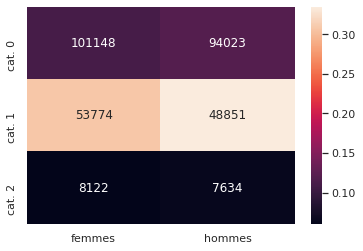

In [ ]:
# on normalise les Xij par le chi2
sns.heatmap(xij / chi2, #np.zeros(tab_cont.shape)
            annot=tab_cont,
            fmt='d',
            yticklabels=[f'cat. {x}' for x in tab_cont.index],
            xticklabels=['femmes', 'hommes'])
plt.plot()

print(f"Xi_n = {xij.sum()}")

## Y a-t-il une corrélation entre l'âge des clients et :

### le montant total des achats 

In [ ]:
# on aggrège le prix dépensé total par utilisateurs
df = t_ss_c_ab[['c_id', 'c_age', 'p_price', 'c_age_range']]

df = df.groupby('c_id').agg({
    'c_age': lambda x:x.mode(),
    'c_age_range': lambda x:x.mode(),
    'p_price':'sum'}
).reset_index()
df.columns = ['c_id', 'c_age', 'c_age_range', 'amount']

df.sample()

,c_id,c_age,c_age_range,amount
4445,c_5010,18.0,30-,351.46


#### avec l'age sous forme quantitative

In [ ]:
df2 = df.groupby('c_age').agg({'amount': 'mean'}).reset_index()

##### régression linéaire

In [ ]:
# entrées / sorties
X = df2.c_age.values
y = df2.amount.values

In [ ]:
# Création du modèle
X_sm =  sm.add_constant(X)
model = sm.OLS(y, X_sm).fit()

# calcul de R2 et de la p-valeur
rsquare = model.rsquared
pval = model.pvalues[0]

R-carré=0.56 & p-valeur=0.00


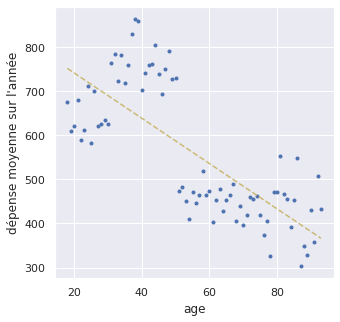

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(X, y, '.')
plt.plot(X, model.predict(X_sm), 'y--')
plt.xlabel('age')
plt.ylabel('dépense moyenne sur l\'année')
print(f"R-carré={rsquare:.2f} & p-valeur={pval:.2f}")

#### avec l'age sous forme qualitative

In [ ]:
age_ranges_amount = {age_range: df.loc[df.c_age_range==age_range, 'amount'] for age_range in age_ranges}

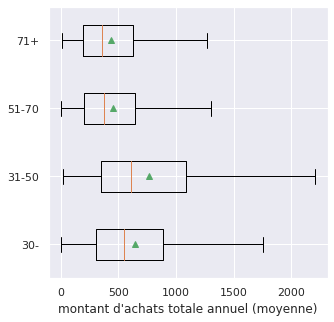

In [ ]:
plt.figure(figsize=(5,5))
plt.boxplot([
    age_ranges_amount['30-'],
    age_ranges_amount['31-50'],
    age_ranges_amount['51-70'],
    age_ranges_amount['71+']
], vert=False, showmeans=True, showfliers=False)

plt.xlabel("montant d'achats totale annuel (moyenne)")
plt.yticks([1,2,3,4], ['30-', '31-50', '51-70', '71+'])
plt.show()

In [ ]:
f, p = st.f_oneway(
    age_ranges_amount['30-'],
    age_ranges_amount['31-50'],
    age_ranges_amount['51-70'],
    age_ranges_amount['71+']
)

In [ ]:
print(f'la f-valeur vaut {f:.2f} et la p-valeur vaut {p:.2e}.')

la f-valeur vaut 267.44 et la p-valeur vaut 5.96e-166.


In [ ]:
def eta2(df, quant, qual):
    # on créé un array qui contient les valeurs de chaques classes séparé dans des sous array
    class_valeurs = []
    for c in  df[quant].unique():
        class_valeurs.append(df.loc[df[quant]==c, qual].values)
    
    # on calcule eta2
    y =  np.concatenate(class_valeurs)
    moyenne_y = y.mean()

    class_info = []
    for y_i in class_valeurs:
        class_info.append({
            'n_i': len(y_i),
            'moyenne_i': y_i.mean()
        })
        
    SCE = sum([ c['n_i'] * (c['moyenne_i'] - moyenne_y)**2 for c in class_info])
    SCT = sum([(y_ij - moyenne_y)**2 for y_ij in y])
    
    return SCE / SCT

In [ ]:
eta2(df, 'c_age_range', 'amount')

0.08540439333852334

### la fréquence d’achat (ie. nombre d'achats par mois par exemple) 

In [ ]:
df = t_ss_c_ab[['c_id', 'c_age', 'c_age_range', 't_month', 'p_id']]

# on met les ages de coté
c_ages = df[['c_id', 'c_age', 'c_age_range']].drop_duplicates()

# on va aggréger les achats...
nb_achats = df[['c_id', 't_month', 'p_id']]
# on compte le nb d'achats par mois
nb_achats = nb_achats.groupby(['c_id', 't_month']).agg({'p_id': 'count'}).reset_index()
nb_achats.columns = ['c_id', 't_month', 'total_achat']
# on fait la moyenne du nombre d'achat mensuel
nb_achats = nb_achats.groupby('c_id').agg({'total_achat': 'mean'}).reset_index()
nb_achats.columns = ['c_id', 'nb_achat_mois_moy']

# on fusionne les deux
df2 = pd.merge(c_ages, nb_achats, on='c_id')

df2.sample()

,c_id,c_age,c_age_range,nb_achat_mois_moy
549,c_1467,64.0,51-70,7.166667


#### avec l'age sous forme quantitative

In [ ]:
df3 = df2.groupby('c_age').agg({'nb_achat_mois_moy': 'mean'}).reset_index()

##### régression linéaire

In [ ]:
# entrées / sorties
X = df3.c_age.values
y = df3.nb_achat_mois_moy.values

In [ ]:
# Création du modèle
X_sm =  sm.add_constant(X)
model = sm.OLS(y, X_sm).fit()

# calcul de R2 et de la p-valeur
rsquare = model.rsquared
pval = model.pvalues[0]

R-carré=0.10 & p-valeur=0.00


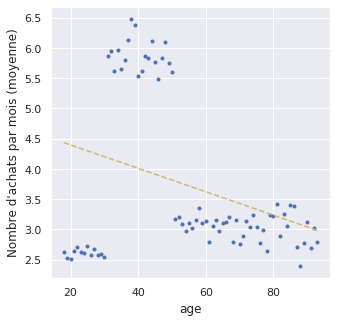

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(X, y, '.')
plt.plot(X, model.predict(X_sm), 'y--')
plt.xlabel('age')
plt.ylabel("Nombre d'achats par mois (moyenne)")
plt.plot()

print(f"R-carré={rsquare:.2f} & p-valeur={pval:.2f}")

#### avec l'age sous forme qualitative

In [ ]:
age_ranges_nb_achat_mois = {age_range: df2.loc[df2.c_age_range==age_range, 'nb_achat_mois_moy'] for age_range in age_ranges}

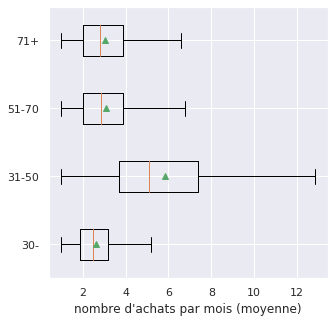

<Figure size 360x360 with 0 Axes>

In [ ]:
plt.figure(figsize=(5,5))
plt.boxplot([
    age_ranges_nb_achat_mois['30-'],
    age_ranges_nb_achat_mois['31-50'],
    age_ranges_nb_achat_mois['51-70'],
    age_ranges_nb_achat_mois['71+']
], vert=False, showmeans=True, showfliers=False)

plt.xlabel("nombre d'achats par mois (moyenne)")
plt.yticks([1,2,3,4], ['30-', '31-50', '51-70', '71+'])
plt.figure(figsize=(5,5))
plt.show()

In [ ]:
f, p = st.f_oneway(
    age_ranges_nb_achat_mois['30-'],
    age_ranges_nb_achat_mois['51-70'],
    age_ranges_nb_achat_mois['71+']
)

print(f'la f-valeur vaut {f:.2f} et la p-valeur vaut {p}.')

la f-valeur vaut 98.45 et la p-valeur vaut 1.0668573689214565e-42.


In [ ]:
eta2(df2, 'c_age_range', 'nb_achat_mois_moy')

0.34156407592367405

### la taille du panier moyen (en nombre d’articles) 

In [ ]:
df = t_ss_c_ab[['c_id', 'c_age', 'c_age_range', 't_sess_id', 'p_id']]

c_ages = df[['c_id', 'c_age', 'c_age_range']].drop_duplicates()

panier_moy = df[['c_id', 't_sess_id', 'p_id']]
# on compte le nb d'articles acheté par mois
panier_moy = panier_moy.groupby(['c_id', 't_sess_id']).count().reset_index()
panier_moy.columns = ['c_id', 't_sess_id', 'nb_prods']
# on fait la moyenne mensuel
panier_moy = panier_moy.groupby('c_id').agg({'nb_prods': 'mean'}).reset_index()
panier_moy.columns = ['c_id', 'panier_moy']

df2 = pd.merge(c_ages, panier_moy, on='c_id')
df2.sample()

,c_id,c_age,c_age_range,panier_moy
5840,c_7736,59.0,51-70,1.777778


#### avec l'age sous forme quantitative

In [ ]:
df3 = df2.groupby('c_age').agg({'panier_moy': 'mean'}).reset_index()

##### régression linéaire

In [ ]:
# entrées / sorties
X = df3.c_age.values
y = df3.panier_moy.values

In [ ]:
# Création du modèle
X_sm =  sm.add_constant(X)
model = sm.OLS(y, X_sm).fit()

# calcul de R2 et de la p-valeur
rsquare = model.rsquared
pval = model.pvalues[0]

R-carré=0.32 & p-valeur=0.00


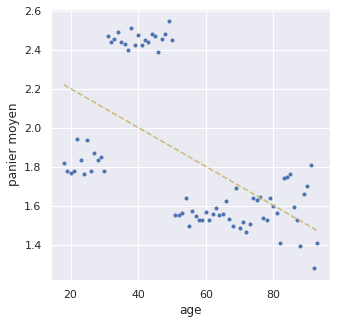

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(X, y, '.')
plt.plot(X, model.predict(X_sm), 'y--')
plt.xlabel('age')
plt.ylabel("panier moyen")
plt.plot()

print(f"R-carré={rsquare:.2f} & p-valeur={pval:.2f}")

#### avec l'age sous forme qualitative

In [ ]:
age_ranges_panier_moy = {age_range: df2.loc[df2.c_age_range==age_range, 'panier_moy'] for age_range in age_ranges}

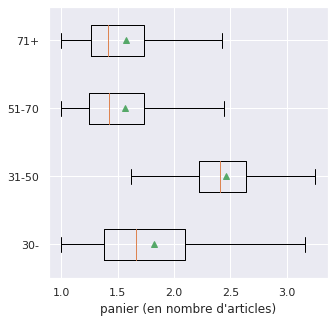

In [ ]:
plt.figure(figsize=(5,5))
plt.boxplot([
    age_ranges_panier_moy['30-'],
    age_ranges_panier_moy['31-50'],
    age_ranges_panier_moy['51-70'],
    age_ranges_panier_moy['71+']
], vert=False, showmeans=True, showfliers=False)

plt.xlabel("panier (en nombre d'articles)")
plt.yticks([1,2,3,4], ['30-', '31-50', '51-70', '71+'])
plt.show()

In [ ]:
f, p = st.f_oneway(
    age_ranges_amount['30-'],
    age_ranges_amount['31-50'],
    age_ranges_amount['51-70'],
    age_ranges_amount['71+']
)
print(f'la f-valeur vaut {f:.2f} et la p-valeur vaut {p:.2e}.')

la f-valeur vaut 267.44 et la p-valeur vaut 5.96e-166.


In [ ]:
eta2(df2, 'c_age_range', 'panier_moy')

0.37554880510198807

### les catégories de produits achetés 

In [ ]:
df = t_ss_c_ab

In [ ]:
cats = t_ss_c_ab.p_cat.unique()
cats

array([1, 0, 2])

In [ ]:
cat_ages = {cat: t_ss_c_ab.loc[t_ss_c_ab['p_cat']==cat, 't_buyer_age'] for cat in cats}

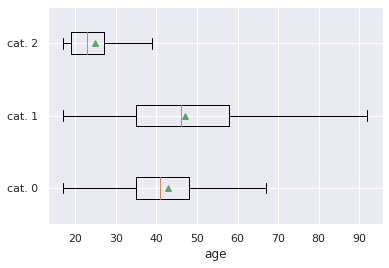

In [ ]:
plt.boxplot([
    cat_ages[0],
    cat_ages[1],
    cat_ages[2]
],
    labels=['cat. 0', 'cat. 1', 'cat. 2'],
    vert=False, showmeans=True, showfliers=False
)
plt.xlabel('age')
plt.show()

In [ ]:
f, p = st.f_oneway(cat_ages[0], cat_ages[1], cat_ages[2])

print(f'la f-valeur vaut {f:.2f} et la p-valeur vaut {p}.')

la f-valeur vaut 19992.37 et la p-valeur vaut 0.0.


In [ ]:
eta2(df, 'c_age_range', 'p_cat')

0.26616959045945715

-------

In [ ]:
# Je fais un tableau de contingence avec crosstab
tab_cont = pd.crosstab(t_ss_c_ab.p_cat, t_ss_c_ab.c_age_range)

In [ ]:
#on calcule le khi-2
chi2, p, dof, expected = st.chi2_contingency(tab_cont.values)

In [ ]:
print(f'Le khi-2 est de {chi2:.2f} et la p-val est de {p}')

Le khi-2 est de 137099.55 et la p-val est de 0.0


--------

#  Proximité des produits 

In [ ]:
from IPython.display import clear_output
import time

In [ ]:
# on ne prend que les transactions concernant les produits de cat. 2
# sinon il y a trop de calculs
df = transactions.loc[transactions.p_cat==2, ['c_id', 'p_id']].drop_duplicates()

p_ids = df.p_id.unique()
n = len(p_ids)

In [ ]:
s = time.time()
# on créé un index des clients pour chaque produits
index_prod = {}
for i, p_id in enumerate(p_ids):
    index_prod[p_id] = df.loc[df.p_id == p_id, 'c_id'].unique()
    
    clear_output(' ')
    print(f"{time.time() - s:.2f}s - {(i+1) / n * 100:.2f}%")

1.44s - 100.00%


In [ ]:
def p2_scht_p1(pid1, pid2):
    return len(np.intersect1d(index_prod[pid1],index_prod[pid2])) / len(index_prod[pid1])

In [ ]:
# paramètres
proba_min_seuil = 0.2 # on ne stocke pas les dépendances dont la prob est inf a..
nb_clients_min = 10 # on ne considère que les produits qui ont au moins n clients

# on calcule pour chaque combinaison de deux produits, la probabilité
s = time.time()
# on va stocker dans un df les résultats de nos calculs
result = pd.DataFrame(columns=['pid_1', 'pid_2', 'pid_2 sachant pid_1'])
index_c = 0
for i, pid1 in enumerate(p_ids):
    for pid2 in p_ids:
        if (pid1 != pid2) and len(index_prod[pid1]) >= nb_clients_min and len(index_prod[pid2]) >= nb_clients_min:
            # mesure
            p =  p2_scht_p1(pid1, pid2)
            # ajout de la mesure
            if p > proba_min_seuil:
                result.loc[index_c] = [pid1,pid2, p]
                index_c += 1
    # affichage du temps
    clear_output(' ')
    print(f"{time.time() - s:.2f}s - {(i+1) / n * 100:.2f}%")  

10.79s - 100.00%


In [ ]:
result.sort_values('pid_2 sachant pid_1', ascending=False).head(5)

,pid_1,pid_2,pid_2 sachant pid_1
8,2_40,2_208,0.636364
978,2_200,2_110,0.600000
1177,2_199,2_102,0.583333
793,2_58,2_102,0.545455
1208,2_195,2_209,0.545455
